In [122]:
import numpy as np
from netCDF4 import Dataset as open_ncfile
from maps_matplot_lib import defVarmme
from modelsDef import defModels
from libToE import findToE, findToE_2thresholds
import glob, os

# ----- Workspace ------

indir_histrcp85 = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'
indir_histNat = '/data/ericglod/Density_binning/Prod_density_april15/mme_histNat/'
indir_piC = '/data/ericglod/Density_binning/Prod_density_april15/mme_piControl/'

models = defModels()

# ----- Work ------

varname = defVarmme('salinity'); v = 'S'
#varname = defVarmme('depth') ; v='Z'
# varname = defVarmme('temp'); v = 'T'

multStd = 2. # detect ToE at multStd std dev of histNat or PiControl

use_piC = False # Signal = (hist-histNat) + RCP8.5-average(histNat), noise = std(histNat)
# use_piC = True # Signal = hist + RCP8.5 - PiControl, noise = std(PiControl)

iniyear = 1860
finalyear = 2100
deltay = 10.

# Choose random file to read only the basic variables and properties common to all files
file = 'cmip5.' + models[1]['name'] + '.historicalNat.ensm.an.ocn.Omon.density.ver-' + \
       models[1]['file_end_histNat'] + '_zon2D.nc'
f = open_ncfile(indir_histNat + file,'r')

lat = f.variables['latitude'][:]; latN = lat.size
lev = f.variables['lev'][:]; levN = lev.size
timN = 240
var = varname['var_zonal_w/bowl']
basinN = 4

# Define variable properties
legVar = varname['legVar']
unit = varname['unit']

# ----- Compute zonal ToE for each simulation ------

nMembers = np.ma.zeros(len(models)) # Initialize array for keeping nb of members per model

for i, model in enumerate(models): # Loop on models

    if model['name'] == 'CSIRO-Mk3-6-0':
        print('Working on', model['name'])
    

        if (use_piC != True) or (use_piC == True and model['name'] != 'GISS-E2-R' and model['name'] != 'FGOALS-g2'
                                 and model['name'] != 'MIROC-ESM'):

            # Read hist+rcp85 files
            listruns = glob.glob(indir_histrcp85 + 'cmip5.' + model['name'] + '.' + '*zon2D.nc')
            nruns = len(listruns)
            nMembers[i] = nruns
            if nruns != 0:
                # Index of common time interval
                tstart = model['props'][2]
                tend = model['props'][3]

                if use_piC == False:
                    # Read histNat ensemble mean
                    filehn = 'cmip5.' + model['name'] + '.historicalNat.ensm.an.ocn.Omon.density.ver-' \
                             + model['file_end_histNat'] + '_zon2D.nc'
                    fhn = open_ncfile(indir_histNat + filehn,'r')

                    # Read var histNat
                    varhn_a = fhn.variables[var][:,1,:,:].squeeze()
                    varhn_p = fhn.variables[var][:,2,:,:].squeeze()
                    varhn_i = fhn.variables[var][:,3,:,:].squeeze()

                    # Read std of histNat (max std of all runs for each model)
                    stdvarhn_a = fhn.variables[var+'Std'][1,:,:].squeeze()
                    stdvarhn_i = fhn.variables[var+'Std'][3,:,:].squeeze()
                    stdvarhn_p = fhn.variables[var+'Std'][2,:,:].squeeze()

                    # Compute time average of the whole histNat series (signal over projection = RCP - mean(histNat))
                    meanvarhn_a = np.ma.mean(varhn_a, axis=0)
                    meanvarhn_p = np.ma.mean(varhn_p, axis=0)
                    meanvarhn_i = np.ma.mean(varhn_i, axis=0)

                    # Reorganise i,j dims in single dimension data (speeds up loops)
                    varnoise_a = np.reshape(stdvarhn_a, (levN*latN))
                    varnoise_p = np.reshape(stdvarhn_p, (levN*latN))
                    varnoise_i = np.reshape(stdvarhn_i, (levN*latN))

                else:
                    # Read PiControl over 240 years + compute mean and std of PiControl
                    filepiC = glob.glob(indir_piC + 'cmip5.' + model['name'] + '.' + '*zon2D.nc')[0]
                    fpiC = open_ncfile(filepiC,'r')
                    varpiC = fpiC.variables[var][-240:,:,:,:]
                    meanvarpiC_a = np.ma.average(varpiC[:,1,:,:], axis=0)
                    meanvarpiC_p = np.ma.average(varpiC[:,2,:,:], axis=0)
                    meanvarpiC_i = np.ma.average(varpiC[:,3,:,:], axis=0)
                    stdvarpiC_a = np.ma.std(varpiC[:,1,:,:], axis=0)
                    stdvarpiC_p = np.ma.std(varpiC[:,2,:,:], axis=0)
                    stdvarpiC_i = np.ma.std(varpiC[:,3,:,:], axis=0)

                    # Reorganise i,j dims in single dimension data (speeds up loops)
                    varnoise_a = np.reshape(stdvarpiC_a, (levN*latN))
                    varnoise_p = np.reshape(stdvarpiC_p, (levN*latN))
                    varnoise_i = np.reshape(stdvarpiC_i, (levN*latN))

                # Initialize toe for each basin (run, density, lat)
                toe1_a = np.ma.masked_all((nruns,levN,latN))
                toe1_p = np.ma.masked_all((nruns,levN,latN))
                toe1_i = np.ma.masked_all((nruns,levN,latN))
                toe2_a = np.ma.masked_all((nruns,levN,latN))
                toe2_p = np.ma.masked_all((nruns,levN,latN))
                toe2_i = np.ma.masked_all((nruns,levN,latN))
                # Initialize output variable
                varToE1 = np.ma.masked_all((nruns,basinN,levN,latN)) # (>1std) (members,basin,density,latitude)
                varToE2 = np.ma.masked_all((nruns,basinN,levN,latN)) # (>2std)
                varsignal_end = np.ma.masked_all((nruns,basinN,levN,latN)) # Save signal (last 5 years)

                # Initialize list for run labels
                run_names = ['']*nruns

                # Loop over number of runs
                for k in range(nruns):

                    namefile = os.path.basename(listruns[k])
                    run_nb = namefile.split('.')[3]
                    run_names[k] = run_nb # Save run label, i.e. 'r1i1p1'

                    print('    . run number', k, run_nb)

                    # Read file
                    fhrcp = open_ncfile(listruns[k],'r')
                    # Read var hist + rcp85
                    # varh_a = fhrcp.variables[var][tstart:tend,1,:,:].squeeze()
                    # varh_p = fhrcp.variables[var][tstart:tend,2,:,:].squeeze()
                    # varh_i = fhrcp.variables[var][tstart:tend,3,:,:].squeeze()
                    varhrcp_a = fhrcp.variables[var][tstart:tend+95,1,:,:].squeeze()
                    varhrcp_p = fhrcp.variables[var][tstart:tend+95,2,:,:].squeeze()
                    varhrcp_i = fhrcp.variables[var][tstart:tend+95,3,:,:].squeeze()

                    # Initialize and fill var_signal for each basin (timN, density, latitude)
                    varsignal_a = np.ma.masked_all((timN,levN,latN))
                    varsignal_p = np.ma.masked_all((timN,levN,latN))
                    varsignal_i = np.ma.masked_all((timN,levN,latN))

                    if use_piC == False:
                        varsignal_a[0:145,:,:] = varhrcp_a[0:145,:,:]-meanvarhn_a
                        varsignal_p[0:145,:,:] = varhrcp_p[0:145,:,:]-meanvarhn_p
                        varsignal_i[0:145,:,:] = varhrcp_i[0:145,:,:]-meanvarhn_i
                        varsignal_a[145:,:,:] = varhrcp_a[145:,:,:]-meanvarhn_a
                        varsignal_p[145:,:,:] = varhrcp_p[145:,:,:]-meanvarhn_p
                        varsignal_i[145:,:,:] = varhrcp_i[145:,:,:]-meanvarhn_i
                    else:
                        varsignal_a = varhrcp_a-meanvarpiC_a
                        varsignal_p = varhrcp_p-meanvarpiC_p
                        varsignal_i = varhrcp_i-meanvarpiC_i

                    # Save signal
                    varsignal_end[k,1,:,:] = np.ma.average(varsignal_a[-5:,:,:],axis=0)
                    varsignal_end[k,2,:,:] = np.ma.average(varsignal_p[-5:,:,:],axis=0)
                    varsignal_end[k,3,:,:] = np.ma.average(varsignal_i[-5:,:,:],axis=0)

                
                    # Reorganise i,j dims in single dimension data (speeds up loops)
                    varsignal_a = np.reshape(varsignal_a, (timN, levN*latN))
                    varsignal_p = np.reshape(varsignal_p, (timN, levN*latN))
                    varsignal_i = np.reshape(varsignal_i, (timN, levN*latN))

                    # Compute ToE as last date when diff hist+RCP - histNat is larger than mult * stddev
                    toe2_a = np.reshape(findToE(varsignal_a, varnoise_a, multStd),(levN,latN)) + 1860
                    toe2_p = np.reshape(findToE(varsignal_p, varnoise_p, multStd),(levN,latN))+ 1860
                    toe2_i = np.reshape(findToE(varsignal_i, varnoise_i, multStd),(levN,latN))+ 1860
                    toe1_a = np.reshape(findToE(varsignal_a, varnoise_a, 1),(levN,latN))+ 1860
                    toe1_p = np.reshape(findToE(varsignal_p, varnoise_p, 1),(levN,latN))+ 1860
                    toe1_i = np.reshape(findToE(varsignal_i, varnoise_i, 1),(levN,latN))+ 1860

                    # Save in output variable
                    varToE1[k,1,:,:] = toe1_a
                    varToE1[k,2,:,:] = toe1_p
                    varToE1[k,3,:,:] = toe1_i
                    varToE2[k,1,:,:] = toe2_a
                    varToE2[k,2,:,:] = toe2_p
                    varToE2[k,3,:,:] = toe2_i

                    if k==1:
                        break

#                 # Mask points because when calculating ToE, masked points (e.g. bathy) are set to 240 (=no emergence)
#                 idx=np.argwhere(varsignal_end.mask==True)
#                 varToE2[idx[:,0],idx[:,1],idx[:,2],idx[:,3]] = np.ma.masked
#                 varToE1[idx[:,0],idx[:,1],idx[:,2],idx[:,3]] = np.ma.masked

Working on CSIRO-Mk3-6-0
    . run number 0 r1i1p1
    . run number 1 r6i1p1


In [123]:
varToE2[1,1,:,:].mask = varsignal_a.mask
varToE2[1,2,:,:].mask = varsignal_p.mask
varToE2[1,3,:,:].mask = varsignal_i.mask

In [124]:
varsignal_a = np.reshape(varsignal_a, (timN,levN,latN))
varsignal_p = np.reshape(varsignal_p, (timN,levN,latN))
varsignal_i = np.reshape(varsignal_i, (timN,levN,latN))

In [125]:
varnoise_a = np.reshape(varnoise_a, (levN,latN))
varnoise_p = np.reshape(varnoise_p, (levN,latN))
varnoise_i = np.reshape(varnoise_i, (levN,latN))

In [126]:
import matplotlib.pyplot as plt

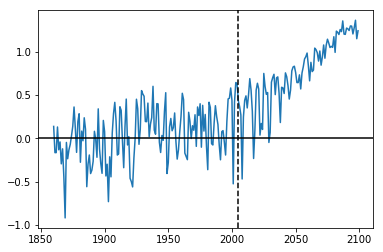

In [127]:
plt.plot(np.arange(1860,2100),varsignal_p[:,5,90])
# plt.plot(np.arange(1860,2100),varsignal_p[:,40,90])
# plt.plot(np.arange(1860,2100),varsignal_i[:,40,90])
plt.axvline(x=2005,color='k',ls='--')
plt.axhline(y=0,color='k')
plt.show()

In [128]:
varsignal_p.shape

(240, 61, 180)

In [129]:
jump_p = np.ma.where(np.abs(varsignal_p[145,:,:]-varsignal_p[144,:,:])>=0.1,1,0)
jump_a = np.ma.where(np.abs(varsignal_a[145,:,:]-varsignal_a[144,:,:])>=0.1,1,0)
jump_i = np.ma.where(np.abs(varsignal_i[145,:,:]-varsignal_i[144,:,:])>=0.1,1,0)

In [130]:
lat2d,lev2d = np.meshgrid(lat,lev)

In [131]:
indir_histrcp85 = '/home/ysilvy/Density_bining/Yona_analysis/data/hist_rcp85/'
fbowl = open_ncfile(indir_histrcp85+'cmip5.CSIRO-Mk3-6-0.historical-rcp85.r6i1p1.an.ocn.Omon.density.ver-1_zon1D.nc','r')
bowl = np.ma.average(fbowl.variables['ptopsigma'][tend+95-20:tend+95,:,:],axis=0)

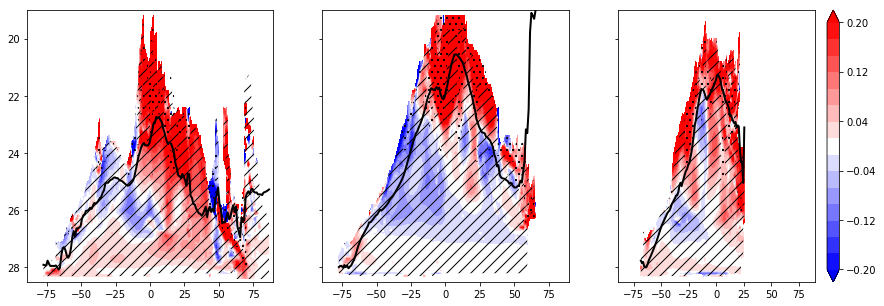

In [132]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,5))
levels = np.linspace(-0.2,0.2,16)
sig = ax[0].contourf(lat2d,lev2d,varsignal_a[143,:,:],cmap='bwr',levels=levels,extend='both')
ax[0].contourf(lat2d,lev2d,jump_a,levels=[0,0.5,1.5],hatches=['//','..'],colors='None')
sig = ax[1].contourf(lat2d,lev2d,varsignal_p[143,:,:],cmap='bwr',levels=levels,extend='both')
ax[1].contourf(lat2d,lev2d,jump_p,levels=[0,0.5,1.5],hatches=['//','..'],colors='None')
sig = ax[2].contourf(lat2d,lev2d,varsignal_i[143,:,:],cmap='bwr',levels=levels,extend='both')
ax[2].contourf(lat2d,lev2d,jump_i,levels=[0,0.5,1.5],hatches=['//','..'],colors='None')
plt.colorbar(sig,ticks=levels[::3])
ax[0].invert_yaxis()
ax[0].plot(lat,bowl[1,:],lw=2,color='k')
ax[1].plot(lat,bowl[2,:],lw=2,color='k')
ax[2].plot(lat,bowl[3,:],lw=2,color='k')
plt.show()

In [133]:
jumpToE_a = np.ma.where(varToE2[1,1,:,:]==2005.0,1,0)
jumpToE_p = np.ma.where(varToE2[1,2,:,:]==2005.0,1,0)
jumpToE_i = np.ma.where(varToE2[1,3,:,:]==2005.0,1,0)

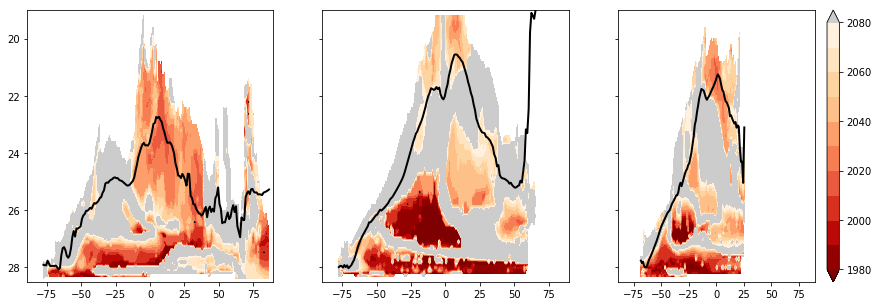

In [134]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(15,5))
ct=ax[0].contourf(lat2d,lev2d,varToE2[1,1,:,:],levels=np.arange(1980,2081,10),cmap='OrRd_r',extend='both')
ct.cmap.set_over('0.8')
ax[0].contourf(lat2d,lev2d,jumpToE_a,levels=[0,0.5,1.5],hatches=['','..'],colors='None')
ct=ax[1].contourf(lat2d,lev2d,varToE2[1,2,:,:],levels=np.arange(1980,2081,10),cmap='OrRd_r',extend='both')
ct.cmap.set_over('0.8')
ax[1].contourf(lat2d,lev2d,jumpToE_p,levels=[0,0.5,1.5],hatches=['','..'],colors='None')
ct=ax[2].contourf(lat2d,lev2d,varToE2[1,3,:,:],levels=np.arange(1980,2081,10),cmap='OrRd_r',extend='both')
ct.cmap.set_over('0.8')
ax[2].contourf(lat2d,lev2d,jumpToE_i,levels=[0,0.5,1.5],hatches=['','..'],colors='None')
ax[0].invert_yaxis()
ax[0].plot(lat,bowl[1,:],lw=2,color='k')
ax[1].plot(lat,bowl[2,:],lw=2,color='k')
ax[2].plot(lat,bowl[3,:],lw=2,color='k')
#ax[1].contour(lat2d,lev2d,varToE2[1,2,:,:],levels=[2005-0.1,2005+0.1],colors='0.3')
plt.colorbar(ct)
plt.show()

In [135]:
idx = np.argwhere(jumpToE_p==1)

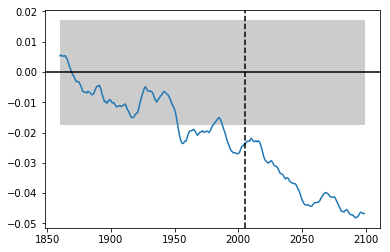

In [140]:
i=2
plt.plot(np.arange(1860,2100),varsignal_p[:,42,62])
plt.axvline(x=2005,color='k',ls='--')
plt.axhline(y=0,color='k')
plt.fill_between(np.arange(1860,2100),2*varnoise_p[42,62],-2*varnoise_p[42,62],color='0.8')
plt.show()

In [112]:
idx[120,:]

array([42, 62])

In [113]:
lev[42],lat[62]

(26.700002670288086, -27.5)

2005